# Lake Effect Snowfall Prediction


## 1. Importing Libraries

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix

%matplotlib inline


## 2. Reading Michigan LES dataset

In [5]:
combined_df = pd.read_csv('LES/MI_14840_2013Fall_2014Spring.csv') 

## 3. Exploratory Data Analysis

In [6]:
combined_df.describe()

,Date_CST,Date_UTC_x,Mean,Centroid_lon,Centroid_lat,Std_lon,Std_lat,Skewness_lon,Skewness_lat,Kurtosis_lon,Kurtosis_lat,Sample Number,Date_UTC_y
count,4.369000e+03,4.330000e+03,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4.363000e+03
mean,2.013561e+07,2.013562e+07,0.148562,-86.727685,43.903336,0.638892,1.226344,0.633697,0.049573,2.997534,1.755657,3.584988,2.013562e+07
std,4.550838e+03,4.550669e+03,0.210334,0.074446,0.154493,0.028039,0.040397,0.103137,0.176354,0.268166,0.155327,0.573380,4.550747e+03
min,2.013100e+07,2.013100e+07,0.000812,-87.149116,42.731292,0.389177,0.622282,-0.052495,-1.043359,1.935527,1.410064,2.000000,2.013100e+07
25%,2.013112e+07,2.013112e+07,0.002022,-86.753975,43.856222,0.627505,1.213380,0.598286,-0.002104,2.876930,1.695515,3.000000,2.013112e+07
50%,2.013123e+07,2.013123e+07,0.002595,-86.733673,43.906049,0.640335,1.230377,0.637683,0.045020,2.973932,1.724313,4.000000,2.013123e+07
75%,2.014021e+07,2.014021e+07,0.290761,-86.710420,43.949023,0.651723,1.244278,0.678638,0.102448,3.089841,1.764495,4.000000,2.014021e+07
max,2.014033e+07,2.014033e+07,0.956265,-86.340049,44.699625,0.818549,1.467391,1.382664,2.265091,6.377330,6.867313,4.000000,2.014033e+07


### a. Dropping redundant Date Time columns

We will keep only one column relevant to date and time and drop others

In [7]:
remove_col = ['Date_CST', 'Time_CST',
              'Date_UTC_x', 'Time_UTC_x','Date_UTC_y', 'Time_UTC_y']
combined_df = combined_df.drop(remove_col, axis = 1) 
combined_df = combined_df.reset_index(drop=True)

Renaming column names by replacing spaces by underscores and removing brackets 

In [8]:
combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
combined_df.columns

/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_53368/1553413785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_53368/1553413785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Index(['date', 'time', 'temp_f', 'rh_%', 'dewpt_f', 'wind_spd_mph',
       'wind_direction_deg', 'peak_wind_gustmph', 'low_cloud_ht_ft',
       'med_cloud_ht_ft', 'high_cloud_ht_ft', 'visibility_mi', 'atm_press_hpa',
       'sea_lev_press_hpa', 'altimeter_hpa', 'precip_in', 'wind_chill_f',
       'heat_index_f', 'mean', 'centroid_lon', 'centroid_lat', 'std_lon',
       'std_lat', 'skewness_lon', 'skewness_lat', 'kurtosis_lon',
       'kurtosis_lat', 'sample_number', 'selected', 'lake_visible',
       'les_exist'],
      dtype='object')

### b. Dropping column containing noisy data

Now let's take a look at unique values in the dataset. We will print all the unique values in each column

In [9]:
for var in combined_df.columns:
    print(combined_df[var].unique())

['2013-10-01' '2013-10-02' '2013-10-03' '2013-10-04' '2013-10-05'
 '2013-10-06' '2013-10-07' '2013-10-08' '2013-10-09' '2013-10-10'
 '2013-10-11' '2013-10-12' '2013-10-13' '2013-10-14' '2013-10-15'
 '2013-10-16' '2013-10-17' '2013-10-18' '2013-10-19' '2013-10-20'
 '2013-10-21' '2013-10-22' '2013-10-23' '2013-10-24' '2013-10-25'
 '2013-10-26' '2013-10-27' '2013-10-28' '2013-10-29' '2013-10-30'
 '2013-10-31' '2013-11-01' '2013-11-02' '2013-11-03' '2013-11-04'
 '2013-11-05' '2013-11-06' '2013-11-07' '2013-11-08' '2013-11-09'
 '2013-11-10' '2013-11-11' '2013-11-12' '2013-11-13' '2013-11-14'
 '2013-11-15' '2013-11-16' '2013-11-17' '2013-11-18' '2013-11-19'
 '2013-11-20' '2013-11-21' '2013-11-22' nan '2013-11-23' '2013-11-24'
 '2013-11-25' '2013-11-26' '2013-11-27' '2013-11-28' '2013-11-29'
 '2013-11-30' '2013-12-01' '2013-12-02' '2013-12-03' '2013-12-04'
 '2013-12-05' '2013-12-06' '2013-12-07' '2013-12-08' '2013-12-09'
 '2013-12-10' '2013-12-11' '2013-12-12' '2013-12-13' '2013-12-14'
 '2013

We observe that there are some irrelevant values like 'M','m' and 'NC'. We don't need these. <br>
So we will replace these noisy values by NaN and further check how many total nulls are present in each column

In [10]:
combined_df.replace('m', np.nan, inplace=True)
combined_df.replace('M', np.nan, inplace=True)
combined_df.replace('NC', np.nan, inplace=True)
combined_df.isnull().sum()

date                     1
time                     1
temp_f                   4
rh_%                     4
dewpt_f                  4
wind_spd_mph            21
wind_direction_deg      29
peak_wind_gustmph     3241
low_cloud_ht_ft        499
med_cloud_ht_ft       2705
high_cloud_ht_ft      3799
visibility_mi            4
atm_press_hpa            8
sea_lev_press_hpa      439
altimeter_hpa            8
precip_in              301
wind_chill_f          1100
heat_index_f          4369
mean                    39
centroid_lon            39
centroid_lat            39
std_lon                 39
std_lat                 39
skewness_lon            39
skewness_lat            39
kurtosis_lon            39
kurtosis_lat            39
sample_number           39
selected                39
lake_visible             6
les_exist                6
dtype: int64

We would now elimate the columns having highest number of nulls.
The top 5 columns having noisy data are - `peak_wind_gustmph`, `high_cloud_ht_ft`, `heat_index_f`, `med_cloud_ht_ft`, `wind_chill_f`, `low_cloud_ht_ft` and `sea_lev_press_hpa`. <br>
So we will drop these columns.

In [11]:
combined_df = combined_df.drop(['peak_wind_gustmph', 'high_cloud_ht_ft', 'heat_index_f', 
                                'med_cloud_ht_ft','wind_chill_f', 'low_cloud_ht_ft',
                               'sea_lev_press_hpa'], axis = 1)
combined_df.shape

(4369, 24)

### c. Dropping null rows from the dataset

Let's now drop all the null rows in the remaining dataset

In [12]:
# Dropping nulls
combined_df = combined_df.dropna()
combined_df = combined_df.reset_index(drop = True)
combined_df.isnull().sum()

date                  0
time                  0
temp_f                0
rh_%                  0
dewpt_f               0
wind_spd_mph          0
wind_direction_deg    0
visibility_mi         0
atm_press_hpa         0
altimeter_hpa         0
precip_in             0
mean                  0
centroid_lon          0
centroid_lat          0
std_lon               0
std_lat               0
skewness_lon          0
skewness_lat          0
kurtosis_lon          0
kurtosis_lat          0
sample_number         0
selected              0
lake_visible          0
les_exist             0
dtype: int64

Now we don't have nulls in the data. Let's again look at the data to see if we are having any other problems

In [13]:
for var in combined_df.columns:
    print(combined_df[var].value_counts())

2013-10-01    24
2014-01-07    24
2014-01-01    24
2013-12-28    24
2013-12-03    24
              ..
2013-11-22    17
2013-12-31    16
2014-01-08    15
2013-11-17    14
2014-03-07    11
Name: date, Length: 182, dtype: int64
07:55    170
17:55    169
20:55    169
19:55    169
18:55    167
        ... 
04:50      1
14:53      1
15:53      1
16:51      1
11:53      1
Name: time, Length: 98, dtype: int64
21    124
19    113
20    110
16    106
23    106
     ... 
-2      4
-4      3
-7      2
-6      1
-5      1
Name: temp_f, Length: 82, dtype: int64
67    165
69    156
64    144
72    138
73    126
     ... 
29      1
31      1
33      1
30      1
23      1
Name: rh_%, Length: 66, dtype: int64
10     127
32     126
31     124
14     117
29     112
      ... 
-12      3
-11      3
54       2
59       2
67       1
Name: dewpt_f, Length: 81, dtype: int64
8     328
9     323
10    320
11    315
0     297
13    281
7     256
6     252
5     244
14    233
15    227
3     183
16    175
17    12

Here we observe that `selected` column is having just one single value, so we can drop it as it doesn't add any information to our dataset

In [14]:
combined_df = combined_df.drop('selected', axis = 1)

### d. Converting categorial data to numeric

Next we will convert the categorical labels `lake_visible` and `les_exist` to numeric

In [15]:
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'N', value=r'0', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'N', value=r'0', regex=True)

In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                4005 non-null   object 
 1   time                4005 non-null   object 
 2   temp_f              4005 non-null   object 
 3   rh_%                4005 non-null   object 
 4   dewpt_f             4005 non-null   object 
 5   wind_spd_mph        4005 non-null   object 
 6   wind_direction_deg  4005 non-null   object 
 7   visibility_mi       4005 non-null   object 
 8   atm_press_hpa       4005 non-null   object 
 9   altimeter_hpa       4005 non-null   object 
 10  precip_in           4005 non-null   object 
 11  mean                4005 non-null   float64
 12  centroid_lon        4005 non-null   float64
 13  centroid_lat        4005 non-null   float64
 14  std_lon             4005 non-null   float64
 15  std_lat             4005 non-null   float64
 16  skewne

Now we will convert all the data types to numeric

In [17]:
combined_df.iloc[:,2:] = combined_df.iloc[:,2:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))
combined_df.dtypes

/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_53368/1936971004.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  combined_df.iloc[:,2:] = combined_df.iloc[:,2:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))


date                   object
time                   object
temp_f                  int64
rh_%                    int64
dewpt_f                 int64
wind_spd_mph            int64
wind_direction_deg      int64
visibility_mi           int64
atm_press_hpa         float64
altimeter_hpa         float64
precip_in             float64
mean                  float64
centroid_lon          float64
centroid_lat          float64
std_lon               float64
std_lat               float64
skewness_lon          float64
skewness_lat          float64
kurtosis_lon          float64
kurtosis_lat          float64
sample_number         float64
lake_visible            int64
les_exist               int64
dtype: object

## 4. Adding Target Column

Adding the target column (LES_SNOWFALL) to the dataset.
Condition = if Temp < 32 and Precip > 0 then Y (1) else N (0)

In [18]:
combined_df['les_snowfall'] = np.where((combined_df['temp_f'] <= 32) & (combined_df['precip_in'] > 0), 1, 0)

We will also drop Temp and Precip columns to prevent the bias in the model

In [19]:
combined_df = combined_df.drop(['temp_f','precip_in'], axis = 1) 
combined_df.head()

,date,time,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,altimeter_hpa,mean,...,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
0,2013-10-01,00:55,77,51,8,160,10,989.9,1012.9,0.001979,...,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,0,0,0
1,2013-10-01,01:55,80,52,6,160,10,990.2,1013.2,0.002175,...,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,0,0,0
2,2013-10-01,02:55,86,53,5,160,10,990.2,1013.2,0.007346,...,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,0,0,0
3,2013-10-01,03:55,86,59,9,190,10,990.2,1013.2,0.001971,...,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,0,0,0
4,2013-10-01,04:55,86,60,9,190,10,990.2,1013.2,0.008081,...,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,0,0,0


In [20]:
from collections import Counter
cnt = Counter(combined_df['les_snowfall'])
cnt

Counter({0: 3751, 1: 254})

### Converting the target variable column to int64 dtype

In [21]:
combined_df = combined_df.astype({'les_snowfall': 'int64'})

The data is quite imbalanced.

## 5. Balancing the dataset

If there is a snowfall on any one hour of the day, we can assume that there waw snow falling for that "day".<br>
So we will extract all the dates in `dates_snowfall` where these was snowfall for any hour of the day, and then assign the `target_snow` column as 1 for all the rows for that day.

In [22]:
dates_snowfall = set()
for index,row in combined_df.iterrows():
    if row['les_snowfall']==1:
        dates_snowfall.add(row['date'])


In [23]:
combined_df['target_snow'] = np.where(combined_df['date'].isin(dates_snowfall),1,0)

Converting the target column to int64

In [24]:
combined_df = combined_df.astype({'target_snow':'int64'})
combined_df.dtypes

date                   object
time                   object
rh_%                    int64
dewpt_f                 int64
wind_spd_mph            int64
wind_direction_deg      int64
visibility_mi           int64
atm_press_hpa         float64
altimeter_hpa         float64
mean                  float64
centroid_lon          float64
centroid_lat          float64
std_lon               float64
std_lat               float64
skewness_lon          float64
skewness_lat          float64
kurtosis_lon          float64
kurtosis_lat          float64
sample_number         float64
lake_visible            int64
les_exist               int64
les_snowfall            int64
target_snow             int64
dtype: object

Checking for one of the dates

In [25]:
combined_df[combined_df['date']=='2014-03-24'][['date','les_snowfall','target_snow']]

,date,les_snowfall,target_snow
3828,2014-03-24,0,1
3829,2014-03-24,0,1
3830,2014-03-24,0,1
3831,2014-03-24,0,1
3832,2014-03-24,1,1
3833,2014-03-24,0,1
3834,2014-03-24,0,1
3835,2014-03-24,0,1
3836,2014-03-24,0,1
3837,2014-03-24,0,1


Now let's check the distribution of the new target variable

In [26]:
cnt = Counter(combined_df['target_snow'])
cnt

Counter({0: 2701, 1: 1304})

## 6. Feature Engineering

### a. Correlation

/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_53368/3404154963.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = combined_df.corr()


<Axes: >

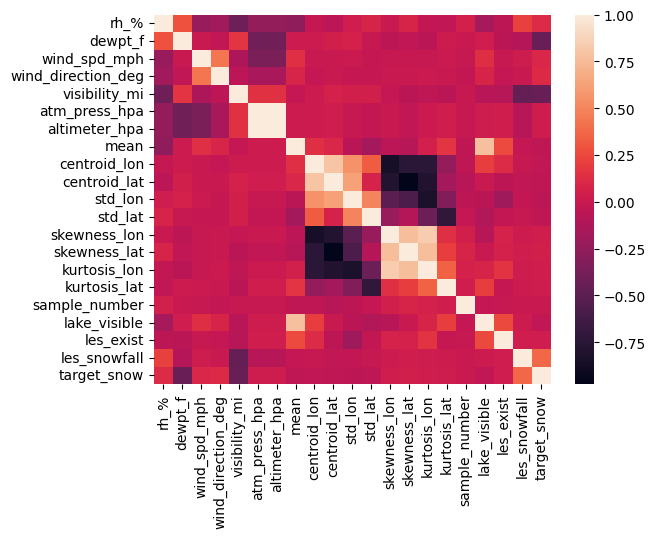

In [27]:
corr = combined_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values )

### b. Dropping highly correlated features
Removing `centroid_lon`, `centroid_lat` and `atm_press_hpa` due it's high correlation with other columns

In [28]:
combined_df = combined_df.drop(['centroid_lon', 'centroid_lat','atm_press_hpa'], axis = 1)
combined_df.shape

(4005, 20)

## 6. Shifting the dataframe to predict 3 days prior

As we want to predict the snowfall some days in advance, we will shift the target column.

In [29]:
def shift_col_hrs(data, hours):
    data3 = data.copy()
    data3['target_snow'] = data.target_snow.shift(-hours)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days i.e 72 hours

In [30]:
s_df = shift_col_hrs(combined_df,72)
print(s_df.shape)
s_df.tail()

(3933, 20)


,date,time,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall,target_snow
3928,2014-03-28,11:55,75,28,18,330,10,1013.9,0.167383,0.733378,1.278658,0.656385,-0.080240,2.727861,1.673418,4.0,1,0,0,0.0
3929,2014-03-28,12:55,72,28,15,340,10,1015.2,0.179933,0.723208,1.277780,0.660659,-0.032906,2.770232,1.656046,3.0,1,0,0,0.0
3930,2014-03-28,13:55,69,28,14,350,10,1015.6,0.192494,0.707747,1.272414,0.672086,0.024177,2.845752,1.652426,4.0,1,0,0,0.0
3931,2014-03-28,15:55,69,27,11,290,10,1019.3,0.194327,0.689577,1.269394,0.686624,0.020473,2.900023,1.683128,3.0,1,0,0,0.0
3932,2014-03-28,16:55,72,27,15,320,10,1020.0,0.173158,0.671477,1.261126,0.687091,0.049914,2.970425,1.695698,4.0,1,0,0,0.0


## 7. Declare feature vector and target variable

In [31]:
s_df.columns

Index(['date', 'time', 'rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist', 'les_snowfall',
       'target_snow'],
      dtype='object')

In [32]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist']

In [33]:
X = pd.DataFrame(s_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = s_df['target_snow']
print("Dependant variable : target_snow")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : target_snow


In [34]:
X.shape, y.shape

((3933, 16), (3933,))

### Scaling the feature set

In [35]:
from sklearn import preprocessing
X = preprocessing.scale(X)

## 8. Splitting into train and test dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
X_train.shape, y_train.shape

((3146, 16), (3146,))

## Decision Tree Classifier

In [42]:
# K-fold splits

cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

In [43]:
# Building our model with K-fold validation and GridSearch to find the best parameters

# Defining all the parameters
params = {
    'max_features': [1, 3, 10],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'criterion': ["entropy", "gini"]
}

# Building model
dtc = DecisionTreeClassifier()

# Parameter estimating using GridSearch
grid = GridSearchCV(dtc, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)

# Fitting the model
grid.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10]},
             scoring='accuracy', verbose=1)

In [44]:
dtc_grid_val_score = grid.best_score_
print('Best Score:', dtc_grid_val_score)
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 0.746927966101695
Best Params: {'criterion': 'gini', 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
Best Estimator: DecisionTreeClassifier(max_features=10, min_samples_split=3)


In [45]:
# Using the best parameters from the grid-search and predicting on test feature dataset(X_test)

dtc_grid= grid.best_estimator_
y_pred = dtc_grid.predict(X_test)

In [46]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test,y_pred), columns=["Predicted A", "Predicted T"], index=["Actual A","Actual T"] )

,Predicted A,Predicted T
Actual A,470,68
Actual T,85,164


In [47]:
# Calculating metrics

dtc_grid_score = accuracy_score(y_test, y_pred)
print('Model Accuracy:', dtc_grid_score)
print('Classification Report:\n', classification_report(y_test, y_pred))

Model Accuracy: 0.8055908513341804
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       538
         1.0       0.71      0.66      0.68       249

    accuracy                           0.81       787
   macro avg       0.78      0.77      0.77       787
weighted avg       0.80      0.81      0.80       787



## Random Forest Classifier

In [48]:

# Defining all the parameters
params = {
    'max_features': [1, 3, 10],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [False],
    'n_estimators' :[100,300],
    'criterion': ["entropy", "gini"]
}

# Building model
rfc = RandomForestClassifier()

# Parameter estimating using GridSearch
grid = GridSearchCV(rfc, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)

# Fitting the model
grid.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['entropy', 'gini'],
                         'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [49]:
rfc_grid_val_score = grid.best_score_
print('Best Score:', rfc_grid_val_score)
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 0.8419491525423728
Best Params: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
Best Estimator: RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=10,
                       min_samples_split=3, n_estimators=300)


In [50]:
# Using the best parameters from the grid-search and predicting on test feature dataset(X_test)

rfc_grid= grid.best_estimator_
y_pred = rfc_grid.predict(X_test)

In [51]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test,y_pred), columns=["Predicted A", "Predicted T"], index=["Actual A","Actual T"] )

,Predicted A,Predicted T
Actual A,504,34
Actual T,51,198


In [52]:
# Calculating metrics

rfc_grid_score = accuracy_score(y_test, y_pred)
print('Model Accuracy:', rfc_grid_score)
print('Classification Report:\n', classification_report(y_test, y_pred))

Model Accuracy: 0.8919949174078781
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       538
         1.0       0.85      0.80      0.82       249

    accuracy                           0.89       787
   macro avg       0.88      0.87      0.87       787
weighted avg       0.89      0.89      0.89       787



## Support Vector machine

In [53]:
# Building our model with K-fold validation and GridSearch to find the best parameters

# Defining all the parameters
params = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'gamma' : [0.001,0.001, 0.01, 0.1, 1]
}

# Building model
svc = SVC(kernel='rbf', probability=True) ## 'rbf' stands for gaussian kernel

# Parameter estimating using GridSearch
grid = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)

# Fitting the model
grid.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.001, 0.01, 0.1, 1]},
             scoring='accuracy', verbose=1)

In [54]:
svm_grid_val_score = grid.best_score_
print('Best Score:', svm_grid_val_score)
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 0.7328389830508474
Best Params: {'C': 10, 'gamma': 0.1}
Best Estimator: SVC(C=10, gamma=0.1, probability=True)


In [55]:
# Using the best parameters from the grid-search and predicting on test feature dataset(X_test)

svm_grid= grid.best_estimator_
y_pred = svm_grid.predict(X_test)

In [56]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test,y_pred), columns=["Predicted A", "Predicted T"], index=["Actual A","Actual T"] )

,Predicted A,Predicted T
Actual A,458,80
Actual T,110,139


In [57]:
# Calculating metrics

svm_grid_score = accuracy_score(y_test, y_pred)
print('Model Accuracy:', svm_grid_score)
print('Classification Report:\n', classification_report(y_test, y_pred))

Model Accuracy: 0.758576874205845
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       538
         1.0       0.63      0.56      0.59       249

    accuracy                           0.76       787
   macro avg       0.72      0.70      0.71       787
weighted avg       0.75      0.76      0.75       787



## Gaussian Naive Bayes

In [59]:
# Building our model with K-fold validation and GridSearch to find the best parameters

# No such parameters for Gaussian Naive Bayes
params = {}

# Building model
gb = GaussianNB()

# Parameter estimating using GridSearch
grid = GridSearchCV(gb, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)

# Fitting the model
grid.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=GaussianNB(), n_jobs=-1, param_grid={},
             scoring='accuracy', verbose=1)

In [60]:
gb_grid_val_score = grid.best_score_
print('Best Score:', gb_grid_val_score)
print('Best Estimator:', grid.best_estimator_)

Best Score: 0.6330508474576271
Best Estimator: GaussianNB()


In [61]:
# Using the best parameters from the grid-search and predicting on test feature dataset(X_test)

gb_grid= grid.best_estimator_
y_pred = gb_grid.predict(X_test)

In [62]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test,y_pred), columns=["Predicted A", "Predicted T"], index=["Actual A","Actual T"] )

,Predicted A,Predicted T
Actual A,366,172
Actual T,79,170


In [63]:
# Calculating metrics

gb_grid_score = accuracy_score(y_test, y_pred)
print('Model Accuracy:', gb_grid_score)
print('Classification Report:\n', classification_report(y_test, y_pred))

Model Accuracy: 0.6810673443456162
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.68      0.74       538
         1.0       0.50      0.68      0.58       249

    accuracy                           0.68       787
   macro avg       0.66      0.68      0.66       787
weighted avg       0.72      0.68      0.69       787



## FINAL RESULTS

In [64]:
score_df = pd.DataFrame(
    [
#         ['Logistic Regression', logreg_grid_score, logreg_grid_val_score],
#         ['K-Nearest Neighbors', knn_grid_score, knn_grid_val_score],
        ['Gaussian Naïve Bayes', gb_grid_score, gb_grid_val_score],
        ['Support Vector Machines', svm_grid_score, svm_grid_val_score],
        ['Decision Tree Classifier', dtc_grid_score, dtc_grid_val_score],
        ['Random Forest Tree Classifier', rfc_grid_score, rfc_grid_val_score],
#         ['Artificial Neural Networks', nn_grid_score, nn_grid_val_score],
#         ['GBM - XGBoost', xgb_grid_score, xgb_grid_val_score], 
    ],
    columns= ['Model', 'Test Score', 'Validation Score']
)
score_df['Test Score'] = score_df['Test Score']*100
score_df['Validation Score'] = score_df['Validation Score']*100

In [65]:
score_df

,Model,Test Score,Validation Score
0,Gaussian Naïve Bayes,68.106734,63.305085
1,Support Vector Machines,75.857687,73.283898
2,Decision Tree Classifier,80.559085,74.692797
3,Random Forest Tree Classifier,89.199492,84.194915


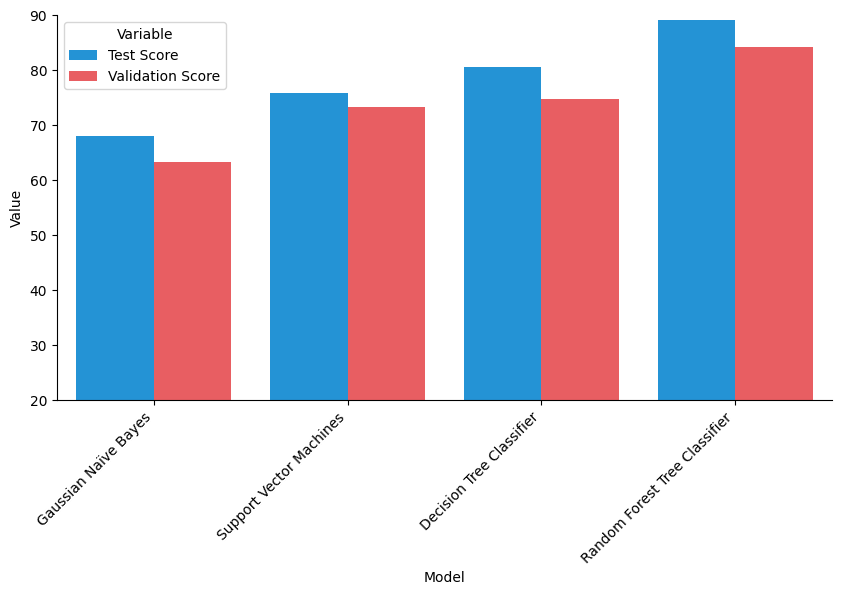

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = score_df.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1, palette=sns.xkcd_palette(["azure", "light red"]))
plt.ylim(20, 90)
plt.xticks(rotation=45, horizontalalignment="right")
# plt.savefig('./plots/result.png')
sns.despine(fig)